# Fraud detection in financial transactions using graph ML techniques.

*Arsenii Belugin a.belugin@innopolis.university*

*Alyona Sinyagina a.sinyagina@innopolis.university*

*Dinara Murtazina d.murtazina@innopolis.university*


## Load datasets

In [ ]:
import pandas as pd
import zipfile
import os

!gdown "https://drive.google.com/uc?id=1HQqS5kSv-thkziQlzc5dhIIggHrPauG7" -O elliptic_data.zip

with zipfile.ZipFile("elliptic_data.zip", 'r') as zip_ref:
    zip_ref.extractall("elliptic_data")

Downloading...
From (original): https://drive.google.com/uc?id=1HQqS5kSv-thkziQlzc5dhIIggHrPauG7
From (redirected): https://drive.google.com/uc?id=1HQqS5kSv-thkziQlzc5dhIIggHrPauG7&confirm=t&uuid=dd1559f8-b459-4ac4-ab22-97099b7ab2cc
To: /content/elliptic_data.zip
100% 149M/149M [00:01<00:00, 129MB/s]


In [ ]:
classes_df = pd.read_csv('/content/elliptic_data/elliptic_bitcoin_dataset/elliptic_txs_classes.csv')
edges_df = pd.read_csv('/content/elliptic_data/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv')
features_df = pd.read_csv('/content/elliptic_data/elliptic_bitcoin_dataset/elliptic_txs_features.csv', header=None)

In [ ]:
classes_df.head()

,txId,class
0,230425980,unknown
1,5530458,unknown
2,232022460,unknown
3,232438397,2
4,230460314,unknown


In [ ]:
edges_df.head()

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


In [ ]:
features_df.head()

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


## Data Preprocessing

In [ ]:
classes_df.columns = ['tx_id'] + ['class']

# Set column names for features dataframe
features_df.columns = ['tx_id'] + [f'feature_{i}' for i in range(1, 167)]
features_df.head()

,tx_id,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_157,feature_158,feature_159,feature_160,feature_161,feature_162,feature_163,feature_164,feature_165,feature_166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [ ]:
merged_df = pd.merge(features_df, classes_df, on='tx_id')
merged_df.head(10)

,tx_id,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_158,feature_159,feature_160,feature_161,feature_162,feature_163,feature_164,feature_165,feature_166,class
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,unknown
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,unknown
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,unknown
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,2
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117,unknown
5,230459870,1,0.961040,-0.081127,-1.201369,1.303743,0.333276,1.480381,-0.061584,-0.163577,...,-0.422589,-0.226790,-0.117629,0.018279,0.277775,0.413931,1.149556,-0.696053,-0.695540,unknown
6,230333930,1,-0.171264,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.161887,...,-0.607306,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,unknown
7,230595899,1,-0.171755,-0.184668,-1.201369,-0.046932,-0.043875,-0.029140,-0.061584,-0.163552,...,0.704641,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,unknown
8,232013274,1,-0.123127,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.112635,...,-0.235168,-0.979074,-0.978556,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399,unknown
9,232029206,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,-0.163645,...,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792,2


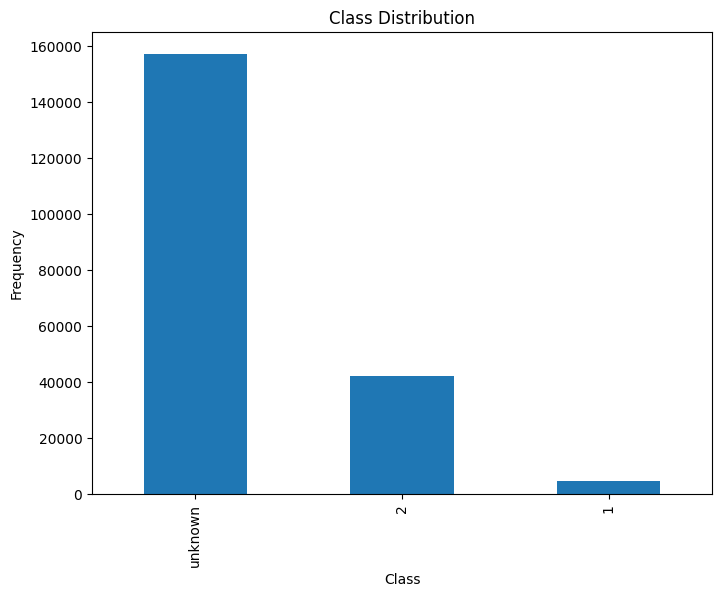

In [ ]:
import matplotlib.pyplot as plt

class_distribution = classes_df['class'].value_counts()

plt.figure(figsize=(8, 6))
class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
import torch

# Clean the class column
merged_df['class'] = merged_df['class'].str.strip()

# Use LabelEncoder to encode class labels
le = LabelEncoder()
merged_df['class'] = le.fit_transform(merged_df['class'])

# Map encoded labels to PyTorch tensor
node_labels = torch.tensor(merged_df['class'].values, dtype=torch.long)

print("Encoded labels:", le.classes_)
print("Example encoded values:", merged_df['class'].unique())
print("Example tensor:", node_labels[:10])

Encoded labels: ['1' '2' 'unknown']
Example encoded values: [2 1 0]
Example tensor: tensor([2, 2, 2, 1, 2, 2, 2, 2, 2, 1])


In [ ]:
from sklearn.preprocessing import StandardScaler

# Normalizing features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(merged_df.iloc[:, 1:-1])
merged_df.iloc[:, 1:-1] = scaled_features

merged_df.head(10)

<ipython-input-10-0ccff18d536f>:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.50565256 -1.50565256 -1.50565256 ...  1.6580424   1.6580424
  1.6580424 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  merged_df.iloc[:, 1:-1] = scaled_features


,tx_id,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_158,feature_159,feature_160,feature_161,feature_162,feature_163,feature_164,feature_165,feature_166,class
0,230425980,-1.505653,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,2
1,5530458,-1.505653,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,2
2,232022460,-1.505653,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,2
3,232438397,-1.505653,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,1
4,230460314,-1.505653,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117,2
5,230459870,-1.505653,0.961040,-0.081127,-1.201369,1.303743,0.333276,1.480381,-0.061584,-0.163577,...,-0.422589,-0.226790,-0.117629,0.018279,0.277775,0.413931,1.149556,-0.696053,-0.695540,2
6,230333930,-1.505653,-0.171264,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.161887,...,-0.607306,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,2
7,230595899,-1.505653,-0.171755,-0.184668,-1.201369,-0.046932,-0.043875,-0.029140,-0.061584,-0.163552,...,0.704641,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,2
8,232013274,-1.505653,-0.123127,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.112635,...,-0.235168,-0.979074,-0.978556,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399,2
9,232029206,-1.505653,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,-0.163645,...,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792,1


0 - illicit

1 - licit

2 - unknown

In [ ]:
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add nodes to the graph
for _, row in merged_df.iterrows():
    G.add_node(
        row['tx_id'],
        features=row.iloc[1:-1].to_numpy(),
        label=row['class']
    )

# Add edges to the graph
for _, row in edges_df.iterrows():
    G.add_edge(row['txId1'], row['txId2'])

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")


Number of nodes: 203769
Number of edges: 234355


In [ ]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.9 MB/s eta 0:00:00


In [ ]:
from torch_geometric.data import Data
import torch

node_features = torch.tensor(
    merged_df.iloc[:, 1:-1].values,
    dtype=torch.float
)

node_labels = torch.tensor(
    merged_df['class'].values,
    dtype=torch.long
)

edge_index = torch.tensor(
    edges_df.values.T,
    dtype=torch.long
)

# Map tx_id in edges_df to sequential indices
tx_id_to_idx = {tx_id: idx for idx, tx_id in enumerate(merged_df['tx_id'])}
edges_df['txId1'] = edges_df['txId1'].map(tx_id_to_idx)
edges_df['txId2'] = edges_df['txId2'].map(tx_id_to_idx)

# Drop edges with missing nodes
edges_df = edges_df.dropna()

edge_index = torch.tensor(edges_df[['txId1', 'txId2']].values.T, dtype=torch.long)

# Creating a PyTorch Geometric Data object
graph_data = Data(
    x=torch.tensor(merged_df.iloc[:, 1:-1].values, dtype=torch.float),
    edge_index=edge_index,  # Edge indices
    y=torch.tensor(merged_df['class'].values, dtype=torch.long)
)

print(graph_data)

Data(x=[203769, 166], edge_index=[2, 234355], y=[203769])


### Data splitting

In [ ]:
known_mask = (graph_data.y == 0) | (graph_data.y == 1)  # Known labels
unknown_mask = graph_data.y == 2                        # Unknown labels

# Separate licit and illicit node indices
licit_indices = (graph_data.y == 1).nonzero(as_tuple=True)[0]
illicit_indices = (graph_data.y == 0).nonzero(as_tuple=True)[0]

# Shuffle the indices for stratified random sampling
licit_perm = licit_indices[torch.randperm(len(licit_indices))]
illicit_perm = illicit_indices[torch.randperm(len(illicit_indices))]

licit_train_size = int(0.8 * len(licit_perm))
licit_val_size = int(0.1 * len(licit_perm))
licit_test_size = len(licit_perm) - licit_train_size - licit_val_size

illicit_train_size = int(0.8 * len(illicit_perm))
illicit_val_size = int(0.1 * len(illicit_perm))
illicit_test_size = len(illicit_perm) - illicit_train_size - illicit_val_size

# Split indices
licit_train = licit_perm[:licit_train_size]
licit_val = licit_perm[licit_train_size:licit_train_size + licit_val_size]
licit_test = licit_perm[licit_train_size + licit_val_size:]

illicit_train = illicit_perm[:illicit_train_size]
illicit_val = illicit_perm[illicit_train_size:illicit_train_size + illicit_val_size]
illicit_test = illicit_perm[illicit_train_size + illicit_val_size:]

# Combine train, val, and test indices
train_indices = torch.cat([licit_train, illicit_train])
val_indices = torch.cat([licit_val, illicit_val])
test_indices = torch.cat([licit_test, illicit_test])

# Shuffle indices
train_indices = train_indices[torch.randperm(len(train_indices))]
val_indices = val_indices[torch.randperm(len(val_indices))]
test_indices = test_indices[torch.randperm(len(test_indices))]

# Create boolean masks for PyTorch Geometric data
graph_data.train_mask = torch.zeros(graph_data.num_nodes, dtype=torch.bool)
graph_data.val_mask = torch.zeros(graph_data.num_nodes, dtype=torch.bool)
graph_data.test_mask = torch.zeros(graph_data.num_nodes, dtype=torch.bool)

graph_data.train_mask[train_indices] = True
graph_data.val_mask[val_indices] = True
graph_data.test_mask[test_indices] = True

# Display distribution statistics
train_licit = (graph_data.y[graph_data.train_mask] == 1).sum().item()
train_illicit = (graph_data.y[graph_data.train_mask] == 0).sum().item()
val_licit = (graph_data.y[graph_data.val_mask] == 1).sum().item()
val_illicit = (graph_data.y[graph_data.val_mask] == 0).sum().item()
test_licit = (graph_data.y[graph_data.test_mask] == 1).sum().item()
test_illicit = (graph_data.y[graph_data.test_mask] == 0).sum().item()

pd.DataFrame({
    'Set': ['Training', 'Validation', 'Testing'],
    'Licit': [train_licit, val_licit, test_licit],
    'Illicit': [train_illicit, val_illicit, test_illicit],
    'Total': [train_licit + train_illicit, val_licit + val_illicit, test_licit + test_illicit],
    'Licit (%)': [100 * train_licit / (train_licit + train_illicit),
                  100 * val_licit / (val_licit + val_illicit),
                  100 * test_licit / (test_licit + test_illicit)],
    'Illicit (%)': [100 * train_illicit / (train_licit + train_illicit),
                    100 * val_illicit / (val_licit + val_illicit),
                    100 * test_illicit / (test_licit + test_illicit)]
})


,Set,Licit,Illicit,Total,Licit (%),Illicit (%)
0,Training,33615,3636,37251,90.239188,9.760812
1,Validation,4201,454,4655,90.247046,9.752954
2,Testing,4203,455,4658,90.231859,9.768141


### GraphSAGE

In [ ]:
import torch
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.metrics import f1_score

# Define the GraphSAGE model
class GraphSAGE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

### Training

In [ ]:
model = GraphSAGE(input_dim=graph_data.x.shape[1], hidden_dim=64, output_dim=2)
optimizer = Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Calculating class weights dynamically to address class imbalance
total_nodes = (graph_data.y == 0).sum() + (graph_data.y == 1).sum()
class_weights = torch.tensor([
    total_nodes / (2 * (graph_data.y == 0).sum()),
    total_nodes / (2 * (graph_data.y == 1).sum())
], dtype=torch.float)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(graph_data.x, graph_data.edge_index)
    valid_train_mask = graph_data.train_mask & (graph_data.y >= 0)
    loss = criterion(out[valid_train_mask], graph_data.y[valid_train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Validation or Test evaluation
def evaluate(mask):
    model.eval()
    with torch.no_grad():
        out = model(graph_data.x, graph_data.edge_index)
        valid_mask = mask & (graph_data.y >= 0)
        preds = out[valid_mask].argmax(dim=1)
        labels = graph_data.y[valid_mask]
        f1 = f1_score(labels.cpu(), preds.cpu(), average='weighted')
    return f1


# Training process
best_val_f1 = 0
patience = 10
counter = 0

for epoch in range(50):
    loss = train()
    val_f1 = evaluate(graph_data.val_mask)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        counter += 1

    print(f"Epoch {epoch+1}, Loss: {loss:.4f}, Val F1: {val_f1:.4f}")

    if counter >= patience:
        break

Epoch 1, Loss: 0.7075, Val F1: 0.8324
Epoch 2, Loss: 0.5022, Val F1: 0.8329
Epoch 3, Loss: 0.4143, Val F1: 0.8233
Epoch 4, Loss: 0.3802, Val F1: 0.8304
Epoch 5, Loss: 0.3558, Val F1: 0.8497
Epoch 6, Loss: 0.3304, Val F1: 0.8654
Epoch 7, Loss: 0.3096, Val F1: 0.8790
Epoch 8, Loss: 0.2969, Val F1: 0.8822
Epoch 9, Loss: 0.2839, Val F1: 0.8795
Epoch 10, Loss: 0.2719, Val F1: 0.8768
Epoch 11, Loss: 0.2621, Val F1: 0.8821
Epoch 12, Loss: 0.2499, Val F1: 0.8949
Epoch 13, Loss: 0.2403, Val F1: 0.8997
Epoch 14, Loss: 0.2345, Val F1: 0.8987
Epoch 15, Loss: 0.2267, Val F1: 0.8942
Epoch 16, Loss: 0.2199, Val F1: 0.8941
Epoch 17, Loss: 0.2132, Val F1: 0.9043
Epoch 18, Loss: 0.2052, Val F1: 0.9148
Epoch 19, Loss: 0.1991, Val F1: 0.9199
Epoch 20, Loss: 0.1938, Val F1: 0.9205
Epoch 21, Loss: 0.1882, Val F1: 0.9174
Epoch 22, Loss: 0.1839, Val F1: 0.9206
Epoch 23, Loss: 0.1794, Val F1: 0.9257
Epoch 24, Loss: 0.1745, Val F1: 0.9279
Epoch 25, Loss: 0.1701, Val F1: 0.9276
Epoch 26, Loss: 0.1653, Val F1: 0.

In [ ]:
# Load the best model and test
model.load_state_dict(torch.load("best_model.pth"))
test_f1 = evaluate(graph_data.test_mask)
print(f"Test F1 Score: {test_f1:.4f}")

<ipython-input-17-665048c6b996>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


Test F1 Score: 0.9516


### Prediction

In [ ]:
def predict(transaction_features, model, device='cpu'):
    """
    Predict whether a transaction is illicit (0) or licit (1).

    Args:
        transaction_features (torch.Tensor): The feature vector of the transaction (1D tensor).
        model (torch.nn.Module): The trained GNN model.
        device (str): Device to perform computation ('cpu' or 'cuda').

    Returns:
        int: Predicted class (0 for licit, 1 for illicit).
    """
    model.eval()
    transaction_features = transaction_features.to(device)
    model = model.to(device)

    with torch.no_grad():
        # Create a self-loop edge index for the single transaction
        edge_index = torch.tensor([[0], [0]], dtype=torch.long, device=device)

        # Forward pass
        logits = model(transaction_features.unsqueeze(0), edge_index)
        predicted_class = logits.argmax(dim=1).item()

    return predicted_class


### Confusion Matrix

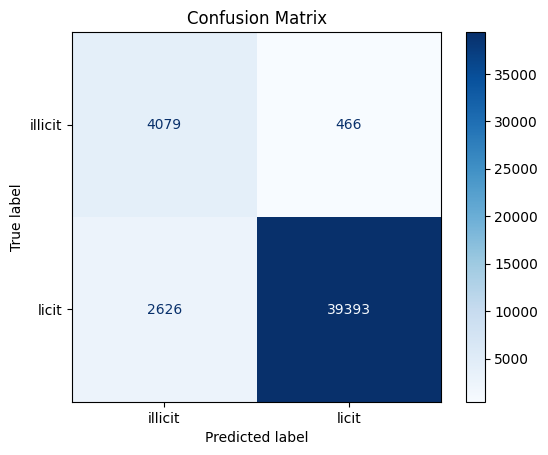

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

true_labels = []
predicted_labels = []

# Loop over nodes with known labels (licit or illicit)
for transaction_id in (graph_data.y >= 0).nonzero(as_tuple=True)[0]:
    transaction_features = graph_data.x[transaction_id]
    prediction = predict(transaction_features, model)
    true_labels.append(graph_data.y[transaction_id].item())
    predicted_labels.append(prediction)

cm = confusion_matrix(true_labels, predicted_labels, labels=[0, 1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['illicit', 'licit'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()


### Example for first 10 transactions

In [ ]:
# Create a mapping from PyTorch Geometric node indices to the original transaction IDs (tx_id)
index_to_tx_id = {idx: tx_id for idx, tx_id in enumerate(merged_df['tx_id'])}

# Loop over the first 10 nodes in the graph
for transaction_id in range(10):

    real_tx_id = index_to_tx_id[transaction_id]
    transaction_features = graph_data.x[transaction_id]
    prediction = predict(transaction_features, model)
    print(f"Transaction {real_tx_id} is {'illicit' if prediction == 0 else 'licit'}")

Transaction 230425980 is licit
Transaction 5530458 is licit
Transaction 232022460 is licit
Transaction 232438397 is licit
Transaction 230460314 is licit
Transaction 230459870 is licit
Transaction 230333930 is licit
Transaction 230595899 is licit
Transaction 232013274 is licit
Transaction 232029206 is licit


# **Analysys of model predictions**

In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def batch_predict(graph_data, model, device='cpu'):
    """
    Predict the class for all transactions in the graph.

    Args:
        graph_data (Data): PyTorch Geometric data object containing transaction features.
        model (torch.nn.Module): The trained GNN model.
        device (str): Device to perform computation ('cpu' or 'cuda').

    Returns:
        np.ndarray: Array of predicted classes (0 for licit, 1 for illicit).
    """
    model.eval()
    model = model.to(device)
    predictions = []

    with torch.no_grad():
        for i in range(graph_data.x.size(0)):
            transaction_features = graph_data.x[i].to(device)
            edge_index = torch.tensor([[0], [0]], dtype=torch.long, device=device)
            logits = model(transaction_features.unsqueeze(0), edge_index)
            predicted_class = logits.argmax(dim=1).item()
            predictions.append(predicted_class)

    return np.array(predictions)

predicted_labels = batch_predict(graph_data, model, device='cpu')

plt.figure(figsize=(8, 6))
sns.countplot(x=predicted_labels, palette="coolwarm")
plt.title("Predicted Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=["Illicit", "Licit"])
plt.savefig("predicted_class_distribution.png")
plt.close()

print("Class distribution plot saved to 'predicted_class_distribution.png'")


<ipython-input-22-3d0a822c0d62>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=predicted_labels, palette="coolwarm")


Class distribution plot saved to 'predicted_class_distribution.png'


In [23]:
model.eval()

transaction_features_batch = graph_data.x
edge_index = graph_data.edge_index

# Compute probabilities using the trained model
with torch.no_grad():
    logits = model(transaction_features_batch, edge_index)
    probabilities = torch.softmax(logits, dim=1).cpu().numpy()

probabilities_transposed = probabilities.T

# Heatmap for both classes
plt.figure(figsize=(12, 4))
sns.heatmap(
    probabilities_transposed,
    cmap="coolwarm",
    cbar=True,
    xticklabels=False,
    yticklabels=["P(Illicit)", "P(Licit)"]
)
plt.title("Class Probabilities Heatmap")
plt.savefig("class_probabilities_heatmap.png")
plt.close()
print("Class probabilities heatmap saved to 'class_probabilities_heatmap.png'")



Class probabilities heatmap saved to 'class_probabilities_heatmap.png'


In [24]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

transaction_features_batch = graph_data.x
edge_index = graph_data.edge_index

model.eval()

with torch.no_grad():
    node_embeddings = model(transaction_features_batch, edge_index)

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(node_embeddings.cpu().numpy())

# Scatter plot of the 2D embeddings
plt.figure(figsize=(10, 8))
plt.scatter(
    reduced_embeddings[:, 0],
    reduced_embeddings[:, 1],
    c=predicted_labels,
    cmap="coolwarm",
    alpha=0.6
)
plt.title("2D Node Embedding Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Class (Licit = 1, Illicit = 0)")
plt.savefig("node_embedding_visualization.png")
plt.close()

print("Node embedding visualization saved to 'node_embedding_visualization.png'")


Node embedding visualization saved to 'node_embedding_visualization.png'
